## Acoustic Signal Processing for Bioacoustics
### 02 - Autocorrelation

In this notebook, we will investigate the autocorrelation function and how it can be useful for estimating times between similar acoustic events, e.g. a repeated bird call. 

Written by: Randall Ali (contact r.ali@surrey.ac.uk for questions/errors/suggestions!)


Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [5]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
import acoustics as ac # We use this for the noise generators: https://github.com/python-acoustics/python-acoustics/tree/master
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl


### White noise and its properties

In signal processing, noise is considered to be an unwanted signal that interferes with communication, perception, measurement or processing of an information-bearing signal. In other contexts, however, noise may in fact be a desired signal and in music for instance, it is considered as a fundamental tool of expression  (https://en.wikipedia.org/wiki/Noise_music). Nevertheless, understanding noise and its properties can give us a deeper insight on how we can use it for our particular application. In signal processing this can be crucial for system modelling, or in acoustics it can be used as an important test signal. 

There are many different types of noise which we will get to in a moment, but let's first have a look at one of the most commonly used types of noises - white noise. For importing various types of noises, we have used the noise generator from https://github.com/python-acoustics/python-acoustics. 

So let's go ahead and firstly generate a white noise signal and listen to it.
The function only specifies the number of samples of noise to generate, so we will have to assign as sampling frequency in order to listen to it. 

White noise:


Text(0, 0.5, 'Amplitude')

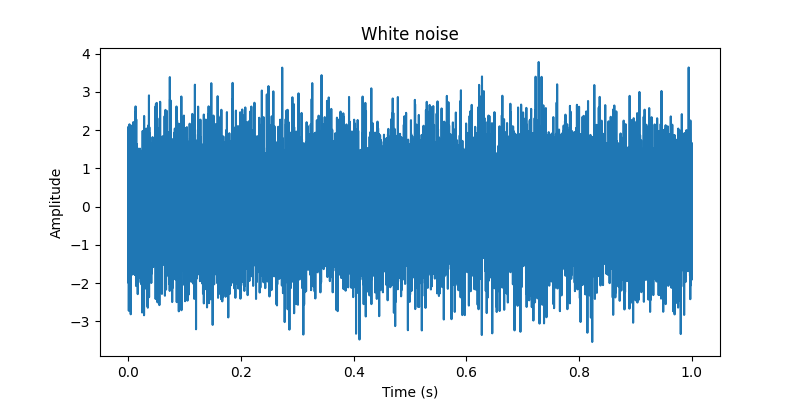

In [6]:
# Let's generate 1 second of white noise at a sampling frequency of fs = 16 kHz

fs = 16000 # sampling freq (Hz)
T = 1 # (Time for noise generation)
N = T*fs

t = np.arange(0,N,1)*(1/fs) # time vector
y = ac.generator.white(N) # generate noise signal (you can change generator.white to generator.pink for pink noise)

# Listen
print("White noise:")
IPython.display.display(Audio(y.T, rate=fs))

# Plot
fig, axes = plt.subplots(figsize=(8, 4)) 
axes.plot(t, y)
axes.set_title('White noise')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')


### Autocorrelation

The autocorrelation is a fundamental property of a signal which tells us something about how the samples within that signal are related to one another. For a zero-mean continuous-time signal of length $T$ (seconds), $y(t)$, the autocorrelation, $r_{yy}(\tau)$ is defined as follows:

\begin{equation}
r_{yy}(\tau) = \frac{1}{T}\int_{0}^{T} y(t)y(t-\tau) dt
\end{equation}

In this equation $\tau$ is what is referred to as a 'lag' and essentially represents a time-shift of the signal, $y(t)$. So essentially, the autocorrelation, $r_{yy}(\tau)$ is a measure of the correlation between the time-shifted version of the signal at lag $\tau$ and the signal itself. We can imagine this process as sliding shifted versions of the signal over itself and computing the integral.

This becomes a bit easier to visualise and think about when we consider discrete-time signals. For a zero-mean discrete-time signal of length N, $y[n]$, sampled at $f_{s}$, the autocorrelation, $r_{yy}[k]$ is similarly defined as follows:

\begin{equation}
r_{yy}[k] = \frac{1}{N} \sum_{0}^{N-1} y[n]y[n-k]
\end{equation}

where $N = T*dt = T/f_s$ and $k$ is the lag. Whereas $\tau$ in the continuous-time case could take any value of time, in the discrete-time case, the lags, $k$ are constrained to integer multiples of $1/f_s$. So let us compute the discrete-time autocorrelation for our white noise signal and see what this tells us about our signal. 

In [3]:
# In order to compute the autocorrelation, we need to zero-pad the signal y[n] 
# with N zeros before the start of the signal and N zeros after. We will then create a copy of this
# signal and shift it accordingly by the lags to obtain ryy[k]
# We will build a function to do this so we can analyse other signals later

# Note - my function here is not very efficient, so it may take a bit of time to run depending on your sampling freq. 

def autocorr(y):
    
    N = len(y)
    
    # Create some empty vectors
    y_zp = np.zeros([3*N]) 
    y_zp_shift_init = np.zeros([3*N]) 
    ryy = np.zeros([2*N]) 
    lags = np.zeros([2*N])

    y_zp[N:2*N] = y # zero padded original signal
    y_zp_shift_init[0:N] = y # copy of the above signal which we will shift accordingly
    
    # Computing the autocorrelation
    for k in np.arange(0,2*N,1):
        y_shifted = np.roll(y_zp_shift_init,k)
        ryy[k] = (1/(2*N))*(y_zp.T@y_shifted)
        lags[k] = k-N # we need to offset the shift index by N to get the true lag value. 
                      # This is just because we essentially offset the y[k] by N samples and zero padded on either side to do the autocorrelation 

    return lags, ryy

# Apply the autocorrelation function:
lags, ryy = autocorr(y)



### An interactive plot

To make some more sense of all of this, let's create an interactive plot. Drag the slider to change the lag 'k'. Observe how the signal is shifted over itself and the value of the autocorrelation at the different lags. What does this tell us about the behaviour of the signal? In the case of white noise, we see that at lag k = 0, $r_{yy}$ is a large value, but then significantly smaller at all other lags. What this means is that samples in the white noise signal are completely uncorrelated with one another and there is only correlation when the signal directly overlaps itself. 

Move the slider to see the computation for different values of k:


interactive(children=(IntSlider(value=0, description='k_off', max=32000), Output()), _dom_classes=('widget-int…

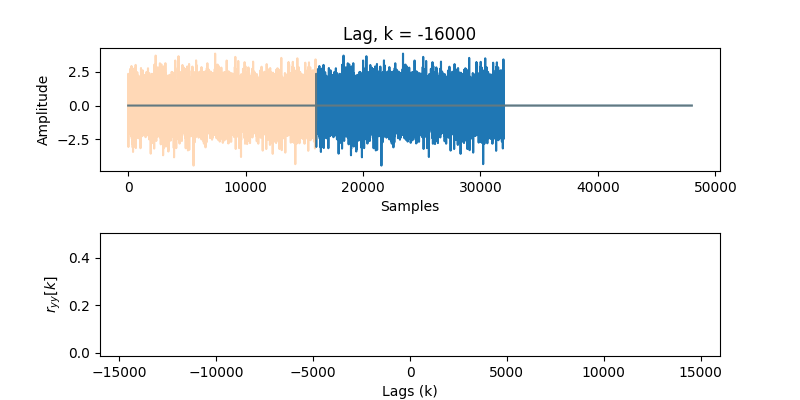

In [4]:
# Repeating the creation of these variables just for the purpose of plotting:
y_zp = np.zeros([3*N]) 
y_zp_shift = np.zeros([3*N]) 
y_zp[N:2*N] = y # zero padded original signal
y_zp_shift[0:N] = y # copy of the above signal which we will shift accordingly


# Do the interactive plot 
fig, axes = plt.subplots(2,1,figsize=(8, 4)) 
fig.subplots_adjust(hspace=0.5)
axes[0].plot(y_zp)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot([], [])
axes[1].set_xlabel('Lags (k)')
axes[1].set_ylabel('$r_{yy}[k]$')
axes[1].set_xlim([lags[0], lags[-1]])
axes[1].set_ylim([np.min(ryy), np.max(ryy)])

line, = axes[0].plot(y_zp_shift,alpha=0.3)
line2, = axes[1].plot([],[],'g-')

def update(k_off = 0):
    
    y_shifted = np.roll(y_zp_shift,k_off)
    line.set_ydata(y_shifted)
    axes[0].set_title('Lag, k = ' + str(k_off-N))
    
    line2.set_data(lags[0:k_off],ryy[0:k_off])

print('Move the slider to see the computation for different values of k:')
interact(update, k_off = (0,2*N,1));

# If anyone knows how to change the position of the slider, contact me :)




### Relation to the power spectral density

The Auto-correlation of a signal is in fact related to its power spectral density (PSD) as follows:

\begin{equation}
F^{-1} (S_{yy}) = r_{yy}[\tau]
\end{equation}

where $S_{yy}$ is the double-sided PSD (i.e. it is computed for all frequencies including the complex conjugate values of the Fourier transform) of the signal $y(t)$ and $F^{-1}$ is the inverse Fourier transform. $S_{yy}$ is defined as follows:
\begin{equation}
S_{yy}(\omega) = \frac{1}{T}|Y(\omega)|^{2}
\end{equation}
where $Y(\omega)$ is the Fourier transform of $y(t)$.

So let's compute the PSD of our signal and verify if this is indeed true!

Text(0, 0.5, 'Autocorrelation')

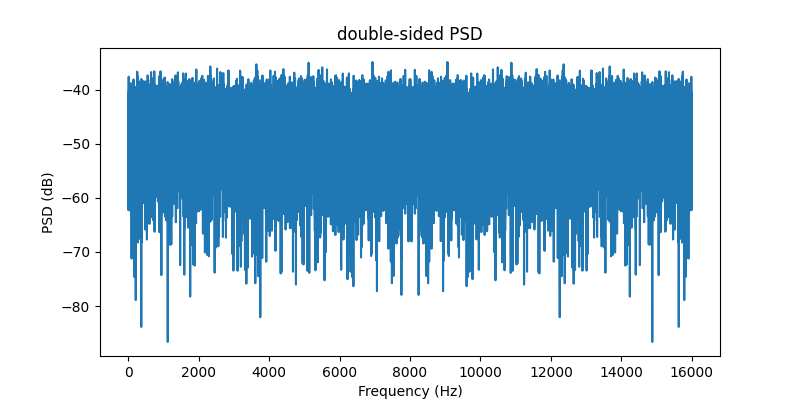

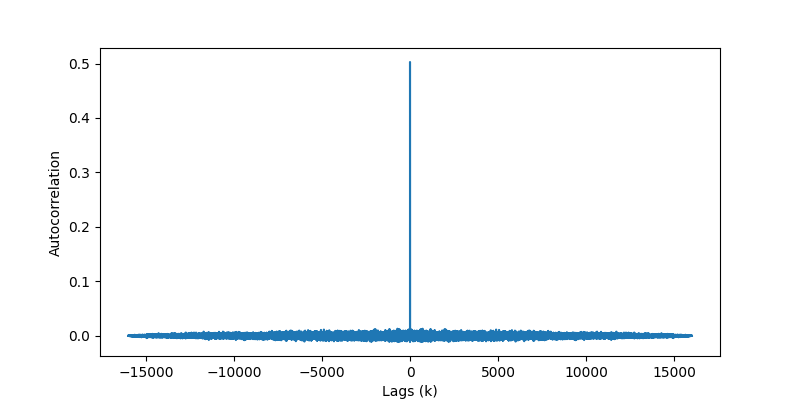

In [14]:
# Computing the PSD of the white noise signal
# Building functions for single-sided and double-sided PSD

def PSD(y, fs, kind):
    N = len(y); dt = 1/fs; df = fs/N; T = N*dt
    Y = np.fft.fft(y) * dt # multiply by dt to obtain the linear spectrum (necessary for parseval's theorem)
    
    if kind == 'double':
        f = np.arange(0,fs,df)
        P = (1/T)*np.abs(Y)*np.abs(np.conj(Y))
        
    elif kind == 'single':
        f = np.arange(0,fs/2+df,df)
        S = (1/T)*np.abs(Y)*np.abs(np.conj(Y))
        P = S[0:N//2+1]
    
    return f, P

PSD_type = 'double' # single or double
freq, Sxx = PSD(y_zp[0:2*N], fs, kind=PSD_type) # PSD of the zero-padded signal

fig, axes = plt.subplots(figsize=(8, 4)) 
axes.plot(freq, 10*np.log10(Sxx))
axes.set_title(str(PSD_type)+'-sided PSD')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('PSD (dB)')

# # This is a check that parsevals theorem holds. The two values should be equal.
# df = fs/len(y_zp)
# print(np.sum(y_zp**2)/len(y_zp))
# print(np.sum(PSD)*df)

# If we take the inverse Fourier transform of the PSD , we should get the autocorrelation

def autocorr_invpsd(Sxx, fs):
    N = len(Sxx)//2
    ryy_hat = np.real(np.fft.ifft(Sxx))*fs # multiplied by fs for the right scaling
    
    #re-order the values so it aligns with the lags as in previous plot
    ryy_hat_reorder = np.zeros(len(ryy_hat))
    ryy_hat_reorder[0:N]=ryy_hat[N:]
    ryy_hat_reorder[N:]=ryy_hat[0:N]
    
    lags = np.arange(-N,N,1)
    
    return lags, ryy_hat_reorder


lags, ryy_hat_reorder = autocorr_invpsd(Sxx, fs)
    
fig, axes = plt.subplots(figsize=(8, 4)) 
axes.plot(lags,(ryy_hat_reorder))
axes.set_xlabel('Lags (k)')
axes.set_ylabel('Autocorrelation')

### Using a bioacoustic signal

So now that we understand a bit about the concept of autocorrelation, we can have a look at the autocorrelation of a any signal, particularly a bioacoustic one. Below I've read in an audio file taken from Xeno Canto (https://xeno-canto.org/explore?query=nr:42541), a Eurasian Bittern which is making some periodic calls. Let's have a look to see if the autocorrelation can help us to obtain an estimate for the time between each call. Feel free to read in your own audio signal and run the script below.


Move the slider to see the autocorrelation for different values of k:


interactive(children=(IntSlider(value=0, description='k_off', max=109860), Output()), _dom_classes=('widget-in…

Text(0, 0.5, 'Amplitude')

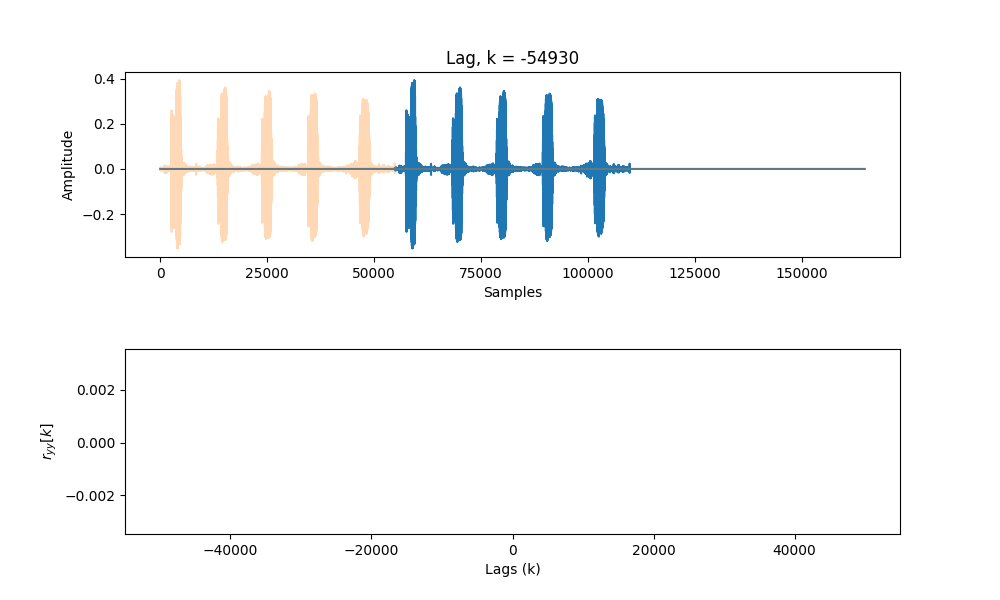

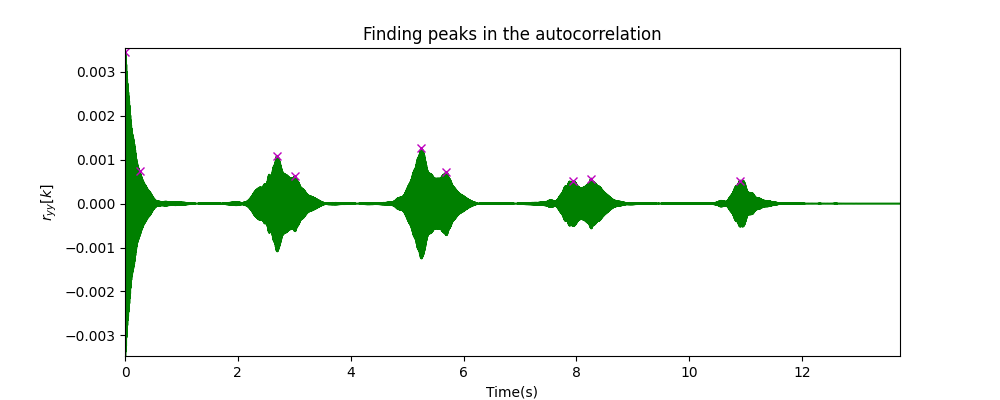

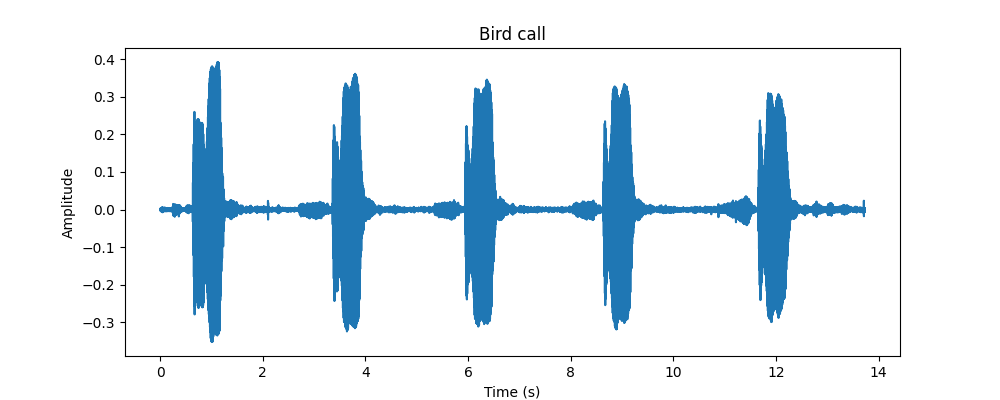

In [15]:
[y,fs] = sf.read('./audio/XC42541_mono_edit.wav') # Read in your audio file
N = len(y)

t = np.arange(0,N,1)*(1/fs) # time vector

# Listen
IPython.display.display(Audio(y.T, rate=fs))



# Let's get the PSD and autocorrelation
y_zp = np.zeros([2*N]) 
y_zp[N:2*N] = y # zero padded original signal

freq, Sxx = PSD(y_zp, fs, kind='double') # PSD of the zero-padded signal
lags, ryy = autocorr_invpsd(Sxx, fs)  # Auto-correlation

# fig, axes = plt.subplots(figsize=(8, 4)) 
# # fig.subplots_adjust(hspace=0.7)
# # axes[0].plot(freq, (Sxx))
# # axes[0].set_title(str(PSD_type)+'-sided PSD')
# # axes[0].set_xlabel('Frequency (Hz)')
# # axes[0].set_ylabel('PSD (dB)')

# axes.plot(lags,ryy)
# axes.set_xlabel('Lags (k)')
# axes.set_ylabel('Autocorrelation')



# Repeating the creation of these variables just for the purpose of plotting:
y_zp = np.zeros([3*N]) 
y_zp_shift = np.zeros([3*N]) 
y_zp[N:2*N] = y # zero padded original signal
y_zp_shift[0:N] = y # copy of the above signal which we will shift accordingly

# Do the interactive plot 
fig, axes = plt.subplots(2,1,figsize=(10, 6)) 
fig.subplots_adjust(hspace=0.5)
axes[0].plot(y_zp)
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot([], [])
axes[1].set_xlabel('Lags (k)')
axes[1].set_ylabel('$r_{yy}[k]$')
axes[1].set_xlim([lags[0], lags[-1]])
axes[1].set_ylim([np.min(ryy), np.max(ryy)])

line, = axes[0].plot(y_zp_shift,alpha=0.3)
line2, = axes[1].plot([],[],'g-')


def update(k_off = 0):
    
    y_shifted = np.roll(y_zp_shift,k_off)
    line.set_ydata(y_shifted)
    axes[0].set_title('Lag, k = ' + str(k_off-N))
    
    line2.set_data(lags[0:k_off],ryy[0:k_off])

print('Move the slider to see the autocorrelation for different values of k:')
interact(update, k_off = (0,2*N,1))



# Finding peaks
ryy_onesided = ryy[N:] # using one half of the autocorrelation function
peaks, _ = signal.find_peaks(ryy_onesided, height=0.0005, distance=1000) # find peaks function from scipy.signal - adjust parameters (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

# Plotting autocorr 
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t, ryy_onesided,'g-')
ax1.plot(t[peaks], ryy_onesided[peaks], "mx",linewidth=2)
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('$r_{yy}[k]$')
ax1.set_xlim([0, N/fs])
ax1.set_ylim([np.min(ryy), np.max(ryy)])
ax1.set_title('Finding peaks in the autocorrelation')


# Time domain Plot
fig, ax2 = plt.subplots(figsize=(10, 4)) 
ax2.plot(t, y)
ax2.set_title('Bird call')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')

# ax2.axis('tight')
# plt.show()


In [16]:
print('The times (in seconds) of the detected peaks are (ignore the second one because that does not correspond to a peak): ')
t_peaks = t[peaks]
print(t_peaks)
#
#
print('This info. can be used to estimate something about the periodicity of the calls or periods within the two types of sounds.')
#
print('For instance, using the first peaks, the times (s) between calls are approximately: ') 
print(t_peaks[2], t_peaks[4]-t_peaks[2], t_peaks[6]-t_peaks[4], t_peaks[8]-t_peaks[6])



The times (in seconds) of the detected peaks are (ignore the second one because that does not correspond to a peak): 
[7.00000e-03 2.57750e-01 2.69050e+00 3.01850e+00 5.25100e+00 5.69500e+00
 7.94175e+00 8.26225e+00 1.09030e+01]
This info. can be used to estimate something about the periodicity of the calls or periods within the two types of sounds.
For instance, using the first peaks, the times (s) between calls are approximately: 
2.6905 2.5605 2.6907499999999995 2.9612500000000006


### References

1. Oppenheim, Alan V., Schafer, Ronald W. and Buck, John R.. Discrete-Time Signal Processing (Ch.2). Second Ed. : Prentice-hall Englewood Cliffs, 1999.
2. Clements, M. (1998). Digital Signal Acquisition and Representation. In: Hopp, S.L., Owren, M.J., Evans, C.S. (eds) Animal Acoustic Communication. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-76220-8_2
